[q=0.02] Layer 51/80: Var noisy=3.676e-11 ± 9.7e-12, Var dep=7.713e-13 ± 2.2e-13
[q=0.02] Layer 52/80: Var noisy=6.493e-11 ± 3.1e-11, Var dep=3.790e-13 ± 8.7e-14
[q=0.02] Layer 53/80: Var noisy=1.011e-10 ± 4.2e-11, Var dep=4.067e-13 ± 9.0e-14
[q=0.02] Layer 54/80: Var noisy=1.423e-10 ± 4.2e-11, Var dep=3.437e-13 ± 1.2e-13
[q=0.02] Layer 55/80: Var noisy=1.047e-10 ± 2.8e-11, Var dep=3.616e-13 ± 7.1e-14
[q=0.02] Layer 56/80: Var noisy=2.827e-10 ± 1.1e-10, Var dep=5.161e-13 ± 1.4e-13
[q=0.02] Layer 57/80: Var noisy=6.839e-10 ± 1.8e-10, Var dep=4.547e-13 ± 1.8e-13
[q=0.02] Layer 58/80: Var noisy=1.099e-09 ± 2.8e-10, Var dep=4.718e-13 ± 1.2e-13
[q=0.02] Layer 59/80: Var noisy=1.700e-09 ± 4.1e-10, Var dep=5.889e-13 ± 2.0e-13
[q=0.02] Layer 60/80: Var noisy=1.815e-09 ± 5.6e-10, Var dep=6.353e-13 ± 1.5e-13
[q=0.02] Layer 61/80: Var noisy=2.662e-09 ± 9.4e-10, Var dep=6.240e-13 ± 1.7e-13
[q=0.02] Layer 62/80: Var noisy=3.749e-09 ± 1.0e-09, Var dep=4.048e-13 ± 9.3e-14
[q=0.02] Layer 63/80: Var no

/var/folders/43/l1qxrlk138533w4m74y89n8h0000gn/T/ipykernel_1680/3814553421.py:110: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


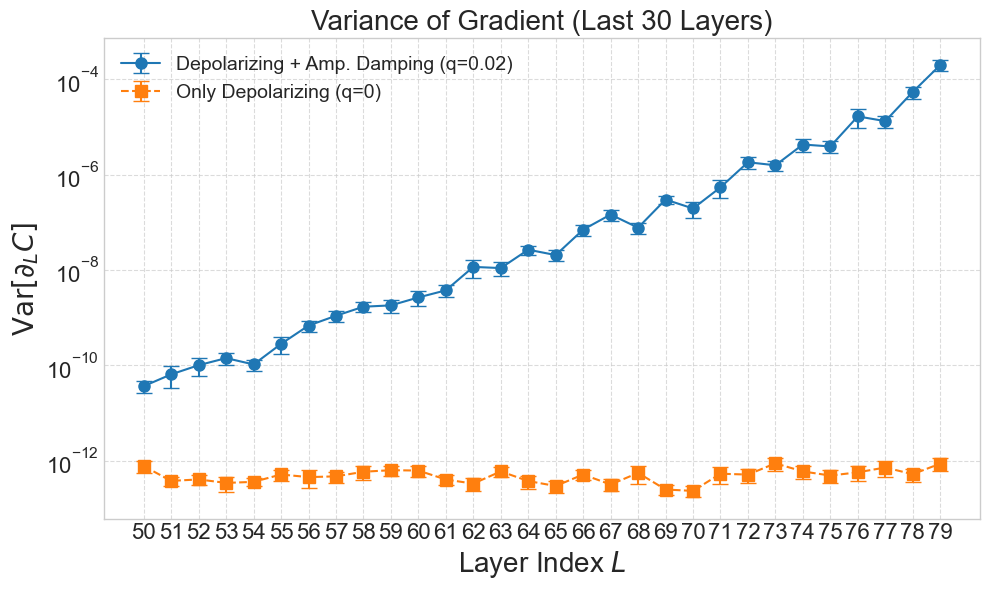

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# PARAMETERS
# ==========================================
nmax = 4
reps = 20
epsd = 1e-4
LL=30

p = 0.02
q_value = 0.02  # amplitude damping value
columsperlayer = 4

nqubits = nmax
depth = 20*nqubits

# ==========================================
# DEVICE
# ==========================================
dev = qml.device('default.mixed', wires=nqubits)

# ==========================================
# CIRCUIT CREATION
# ==========================================
def create_circuit(nqubits, depth, p, q):
    @qml.qnode(dev)
    def circuit(params):
        for L in range(depth):
            # First half
            for i in range(nqubits):
                qml.RX(params[i, 0, L], wires=i)
            for i in range(nqubits // 2):
                qml.CNOT(wires=[2 * i, 2 * i + 1])
            for i in range(nqubits):
                qml.RY(params[i, 1, L], wires=i)
                qml.DepolarizingChannel(p, wires=i)
                qml.AmplitudeDamping(q, wires=i)

            # Second half
            for i in range(nqubits):
                qml.RX(params[i, 2, L], wires=i)
            for i in range(nqubits // 2 - 1 + int(nqubits % 2)):
                qml.CNOT(wires=[2 * i + 1, 2 * i + 2])
            for i in range(nqubits):
                qml.RY(params[i, 3, L], wires=i)
                qml.DepolarizingChannel(p, wires=i)
                qml.AmplitudeDamping(q, wires=i)
        return qml.expval(qml.PauliZ(0))
    return circuit

# ==========================================
# VARIANCE COMPUTATION (LAST LL LAYERS)
# ==========================================
def compute_variances(q_value):
    circuit = create_circuit(nqubits, depth, p, q_value)
    circuit_q0 = create_circuit(nqubits, depth, p, 0)  # baseline only depolarizing

    var_list, err_list = [], []
    var_list_q0, err_list_q0 = [], []

    last_layers = range(depth - LL, depth)  # Only last 20 layers

    for pd in last_layers:
        grad_points = []
        grad_points_q0 = []

        for _ in range(reps):
            params = 2 * np.pi * np.random.rand(nqubits, columsperlayer, depth)

            pdx = np.copy(params)
            psx = np.copy(params)
            pdx[0, -1, pd] += epsd
            psx[0, -1, pd] -= epsd

            grad_points.append((circuit(pdx) - circuit(psx)) / (2 * epsd))
            grad_points_q0.append((circuit_q0(pdx) - circuit_q0(psx)) / (2 * epsd))

        grad_points = np.array(grad_points)
        grad_points_q0 = np.array(grad_points_q0)

        # Variance and standard error of the variance (improved)
        var = np.var(grad_points, ddof=1)
        stderr_var = np.std((grad_points - np.mean(grad_points))**2, ddof=1) / np.sqrt(reps)

        var_q0 = np.var(grad_points_q0, ddof=1)
        stderr_var_q0 = np.std((grad_points_q0 - np.mean(grad_points_q0))**2, ddof=1) / np.sqrt(reps)

        var_list.append(var)
        err_list.append(stderr_var)
        var_list_q0.append(var_q0)
        err_list_q0.append(stderr_var_q0)

        print(f"[q={q_value:.2f}] Layer {pd+1}/{depth}: "
              f"Var noisy={var:.3e} ± {stderr_var:.1e}, Var dep={var_q0:.3e} ± {stderr_var_q0:.1e}")

    return var_list, err_list, var_list_q0, err_list_q0

# ==========================================
# RUN
# ==========================================
var, err, var_q0, err_q0 = compute_variances(q_value)

# ==========================================
# PLOTTING
# ==========================================
x = np.arange(depth - LL, depth)  # exactly LL points to match variance data
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 6))

# Plot noisy (depolarizing + amplitude damping)
plt.errorbar(x, var, yerr=err, fmt='o-', markersize=8, capsize=6,
             color='tab:blue', label=f'Depolarizing + Amp. Damping (q={q_value})')

# Plot baseline (only depolarizing)
plt.errorbar(x, var_q0, yerr=err_q0, fmt='s--', markersize=8, capsize=6,
             color='tab:orange', label='Only Depolarizing (q=0)')

plt.xlabel('Layer Index $L$', fontsize=20)
plt.ylabel(r'$\mathrm{Var}[\partial_L C]$', fontsize=20)
plt.title(f'Variance of Gradient (Last {LL} Layers)', fontsize=20)

plt.legend(fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x, fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')

plt.tight_layout()
plt.savefig(f'effective_depth_variance_last_{LL}_layers.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/43/l1qxrlk138533w4m74y89n8h0000gn/T/ipykernel_86120/745716164.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


KeyError: 0.02

<Figure size 1000x600 with 0 Axes>

/var/folders/43/l1qxrlk138533w4m74y89n8h0000gn/T/ipykernel_86120/84711715.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


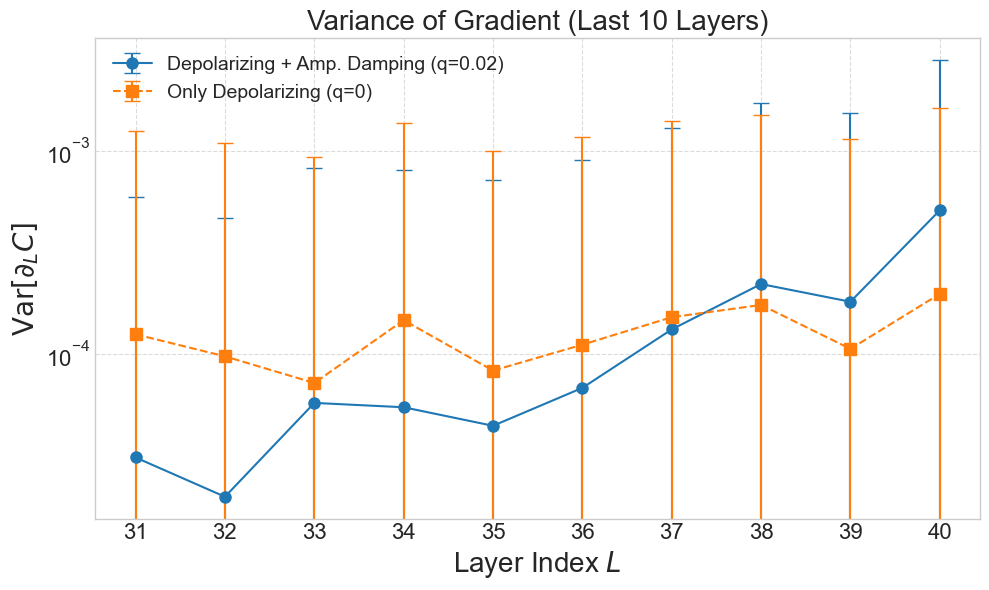

✅ Saved data as effective_depth_variance_last_30_layers_p=0.02_qvals=0.02_0.0.npz


/var/folders/43/l1qxrlk138533w4m74y89n8h0000gn/T/ipykernel_1680/1093648159.py:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


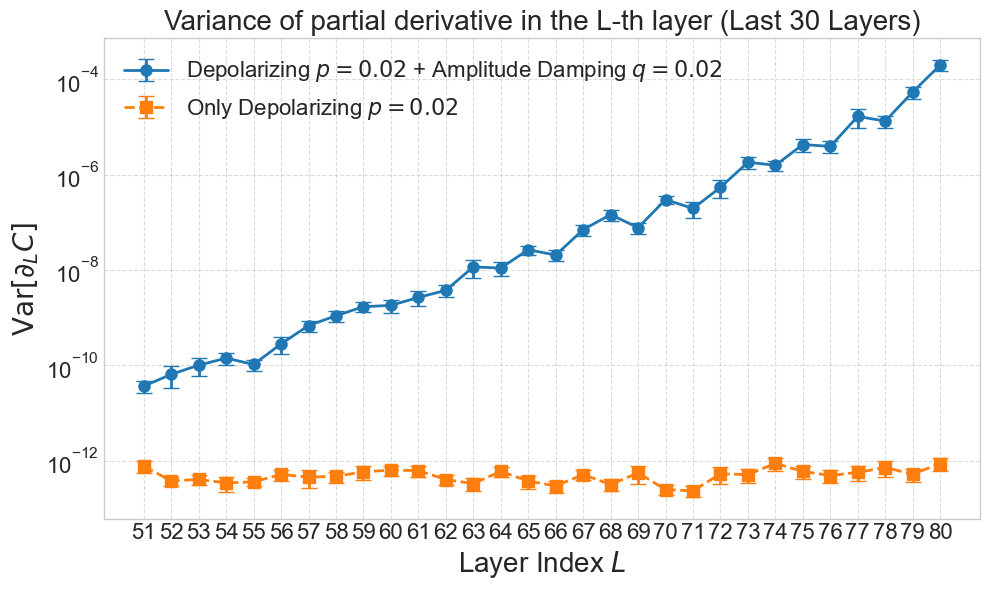

✅ Saved plot as effective_depth_variance_last_30_layers_p=0.02_qvals=0.02_0.0.png


In [16]:
# ==========================================
# SAVE DATA
# ==========================================
results = {
    q_value: (var, err),
    0.0: (var_q0, err_q0)
}

q_vals_str = "_".join([str(q) for q in results.keys()])
filename_data = f'effective_depth_variance_last_{LL}_layers_p={p}_qvals={q_vals_str}.npz'
np.savez(filename_data, results=results)
print(f"✅ Saved data as {filename_data}")

# ==========================================
# PLOTTING
# ==========================================
x = np.arange(depth - LL+1, depth+1)  # exactly LL points to match variance data
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 6))
colors = ["tab:blue", "tab:orange"]

for idx, (q, (vars_q, errs_q)) in enumerate(results.items()):
    if q == 0:
        label = rf"Only Depolarizing $p={p}$"
        linestyle = '--'
        marker = 's'
        
    else:
        label = rf"Depolarizing $p={p}$ + Amplitude Damping $q={q}$"
        linestyle = '-'
        marker = 'o'

    plt.errorbar(
        x,
        vars_q,
        yerr=errs_q,
        marker=marker,
        markersize=8,
        linestyle=linestyle,
        color=colors[idx % len(colors)],
        capsize=6,
        linewidth=2,
        label=label
    )

plt.xlabel('Layer Index $L$', fontsize=20)
plt.ylabel(r'$\mathrm{Var}[\partial_L C]$', fontsize=20)
plt.title(f'Variance of partial derivative in the L-th layer (Last {LL} Layers)', fontsize=20)

plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x, fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')

plt.tight_layout()

# SAVE PLOT
filename_plot = f'effective_depth_variance_last_{LL}_layers_p={p}_qvals={q_vals_str}.png'
plt.savefig(filename_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved plot as {filename_plot}")

✅ Saved data as effective_depth_variance_last_30_layers_p=0.02_qvals=0.02_0.0.npz


/var/folders/43/l1qxrlk138533w4m74y89n8h0000gn/T/ipykernel_1680/1907474011.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


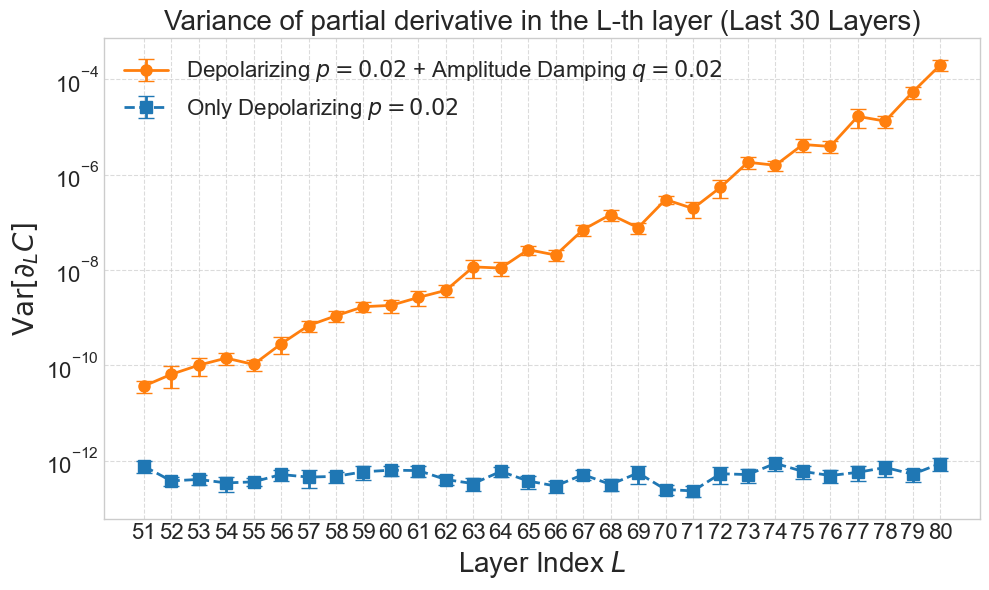

✅ Saved plot as effective_depth_variance_last_30_layers_p=0.02_qvals=0.02_0.0.png


In [17]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# SAVE DATA
# ==========================================
results = {
    q_value: (var, err),
    0.0: (var_q0, err_q0)
}

q_vals_str = "_".join([str(q) for q in results.keys()])
filename_data = f'effective_depth_variance_last_{LL}_layers_p={p}_qvals={q_vals_str}.npz'
np.savez(filename_data, results=results)
print(f"✅ Saved data as {filename_data}")

# ==========================================
# PLOTTING
# ==========================================
x = np.arange(depth - LL + 1, depth + 1)  # exactly LL points to match variance data
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(10, 6))

# Inverted colors: q>0 → orange, q=0 → blue
colors = {
    "damping": "tab:orange",
    "depolarizing": "tab:blue"
}

# Separate results so depolarizing is plotted last
sorted_results = dict(sorted(results.items(), key=lambda kv: 1 if kv[0] == 0 else 0))

for q, (vars_q, errs_q) in sorted_results.items():
    if q == 0:
        label = rf"Only Depolarizing $p={p}$"
        linestyle = '--'
        marker = 's'
        color = colors["depolarizing"]
    else:
        label = rf"Depolarizing $p={p}$ + Amplitude Damping $q={q}$"
        linestyle = '-'
        marker = 'o'
        color = colors["damping"]

    plt.errorbar(
        x,
        vars_q,
        yerr=errs_q,
        marker=marker,
        markersize=8,
        linestyle=linestyle,
        color=color,
        capsize=6,
        linewidth=2,
        label=label
    )

plt.xlabel('Layer Index $L$', fontsize=20)
plt.ylabel(r'$\mathrm{Var}[\partial_L C]$', fontsize=20)
plt.title(f'Variance of partial derivative in the L-th layer (Last {LL} Layers)', fontsize=20)

plt.legend(fontsize=16)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(x, fontsize=16)
plt.yticks(fontsize=16)
plt.yscale('log')

plt.tight_layout()

# SAVE PLOT
filename_plot = f'effective_depth_variance_last_{LL}_layers_p={p}_qvals={q_vals_str}.png'
plt.savefig(filename_plot, dpi=300, bbox_inches='tight')
plt.show()

print(f"✅ Saved plot as {filename_plot}")
